# MLE and MAP

#### Dataset construction

In [31]:
import numpy as np
import matplotlib.pyplot as plt

N = 350
K = 3

theta_true = np.ones((K,))
a, b = 0, 1

'''
Prepare train set
'''
X = np.random.uniform(a, b, (N,))

def GeneralizedVander(X, Phis):
    n = X.shape[0]
    k = len(Phis)
    vander = np.zeros((n, k))
    for i in range(n):
        for j in range(k):
            vander[i, j] = Phis[-j -1](X[i]) # or Phis[j]
    return vander

def f(j):
    return lambda x: x**j

Phis = [f(j) for j in range(K)]

classical_vander = GeneralizedVander(X, Phis)
phi = classical_vander

sigma2 = .25
e = np.random.normal(0, sigma2, (N,))

Y = phi @ theta_true + e

''' 
Prepare test set
'''
Ntest = 150
Xtest = np.random.uniform(a, b, (Ntest,))
e = np.random.normal(0, sigma2, (Ntest,))
phitest = GeneralizedVander(Xtest, Phis)
Ytest = phitest @ theta_true + e

print(X.shape, Y.shape)

(350,) (350,)


In [62]:
from GradientDescent import *

def mle_est(X, Y, K):
    Phi = np.vander(X, K)
    theta_mle = np.linalg.solve(Phi.T@Phi, Phi.T@Y)
    return theta_mle

def mle_est_plus(X, Y, K, descent_type= "NE"):
    '''
    Computes the Maximum Likelihood estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    
    if descent_type == "NE":
        Phi = np.vander(X, K)
        theta_mle = np.linalg.solve(Phi.T@Phi, Phi.T@Y)
        
    elif descent_type == "GD":
        Phi = np.vander(X, K)
        l = genf3(Phi, Y)
        grad_l = gengrad_f3(Phi, Y)
        thetazero = np.zeros((K,))
        thetas, k, *_ = GD_b(f= l, grad_f= grad_l, x0= thetazero, kmax= 400, tolx= 1e-6, tolf= 1e-6, alphastart= 1e-4)
        theta_mle = thetas[k]

    elif descent_type == "SGD":
        
        def el(theta, X, Y):
            Phi = np.vander(X, len(theta))
            return .5*np.linalg.norm(Phi@theta - Y)**2
        
        def grad_el(theta, X, Y): 
            return gengrad_f3(np.vander(X, K), Y)(theta)
        thetazero = np.zeros((K,))
        thetas, *_ = SGD(l= el, grad_l= grad_el, data= (X, Y), w0= thetazero, n_epochs= 30)
        theta_mle = thetas[-1]
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    return theta_mle

def PolRegressor(X, theta):
    K = theta.shape[0]
    Phi = np.vander(X, K)
    Y_reg = Phi @ theta
    return Y_reg

def average_error(theta, Xtest, Ytest):    
    N_test = Xtest.shape[0]
    Y_reg = PolRegressor(Xtest, theta)

    err = np.linalg.norm(Y_reg - Ytest, 2)**2
    return err / N_test

def map_est(X, Y, K, lmbda):
    Phi = np.vander(X, K)
    theta_map = np.linalg.solve(Phi.T@Phi + lmbda * np.identity(K), Phi.T@Y)
    return theta_map

def map_est_plus(X, Y, K, lmbda, descent_type= "NE"):
    '''
    Computes the Maximum A Posteriori estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    
    if descent_type == "NE":
        Phi = np.vander(X, K)
        theta_map = np.linalg.solve(Phi.T@Phi + lmbda * np.identity(K), Phi.T@Y)
        
    elif descent_type == "GD":
        Phi = np.vander(X, K)
        l = genf4(Phi, Y, lmbda)
        grad_l = gengrad_f4(Phi, Y, lmbda)
        thetazero = np.zeros((K,))
        thetas, k, *_ = GD_b(f= l, grad_f= grad_l, x0= thetazero, kmax= 400, tolx= 1e-6, tolf= 1e-6, alphastart= 1e-4)
        theta_map = thetas[k]

    elif descent_type == "SGD":
        def el(theta, X, Y):
            Phi = np.vander(X, len(theta))
            return genf4(Phi, Y, lmbda)(theta)
        
        def grad_el(theta, X, Y): 
            return gengrad_f4(np.vander(X, K), Y, lmbda)(theta)
        thetazero = np.zeros((K,))
        thetas, *_ = SGD(l= el, grad_l= grad_el, data= (X, Y), w0= thetazero, n_epochs= 30)
        theta_map = thetas[-1]
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    return theta_map


#### MLE and MAP

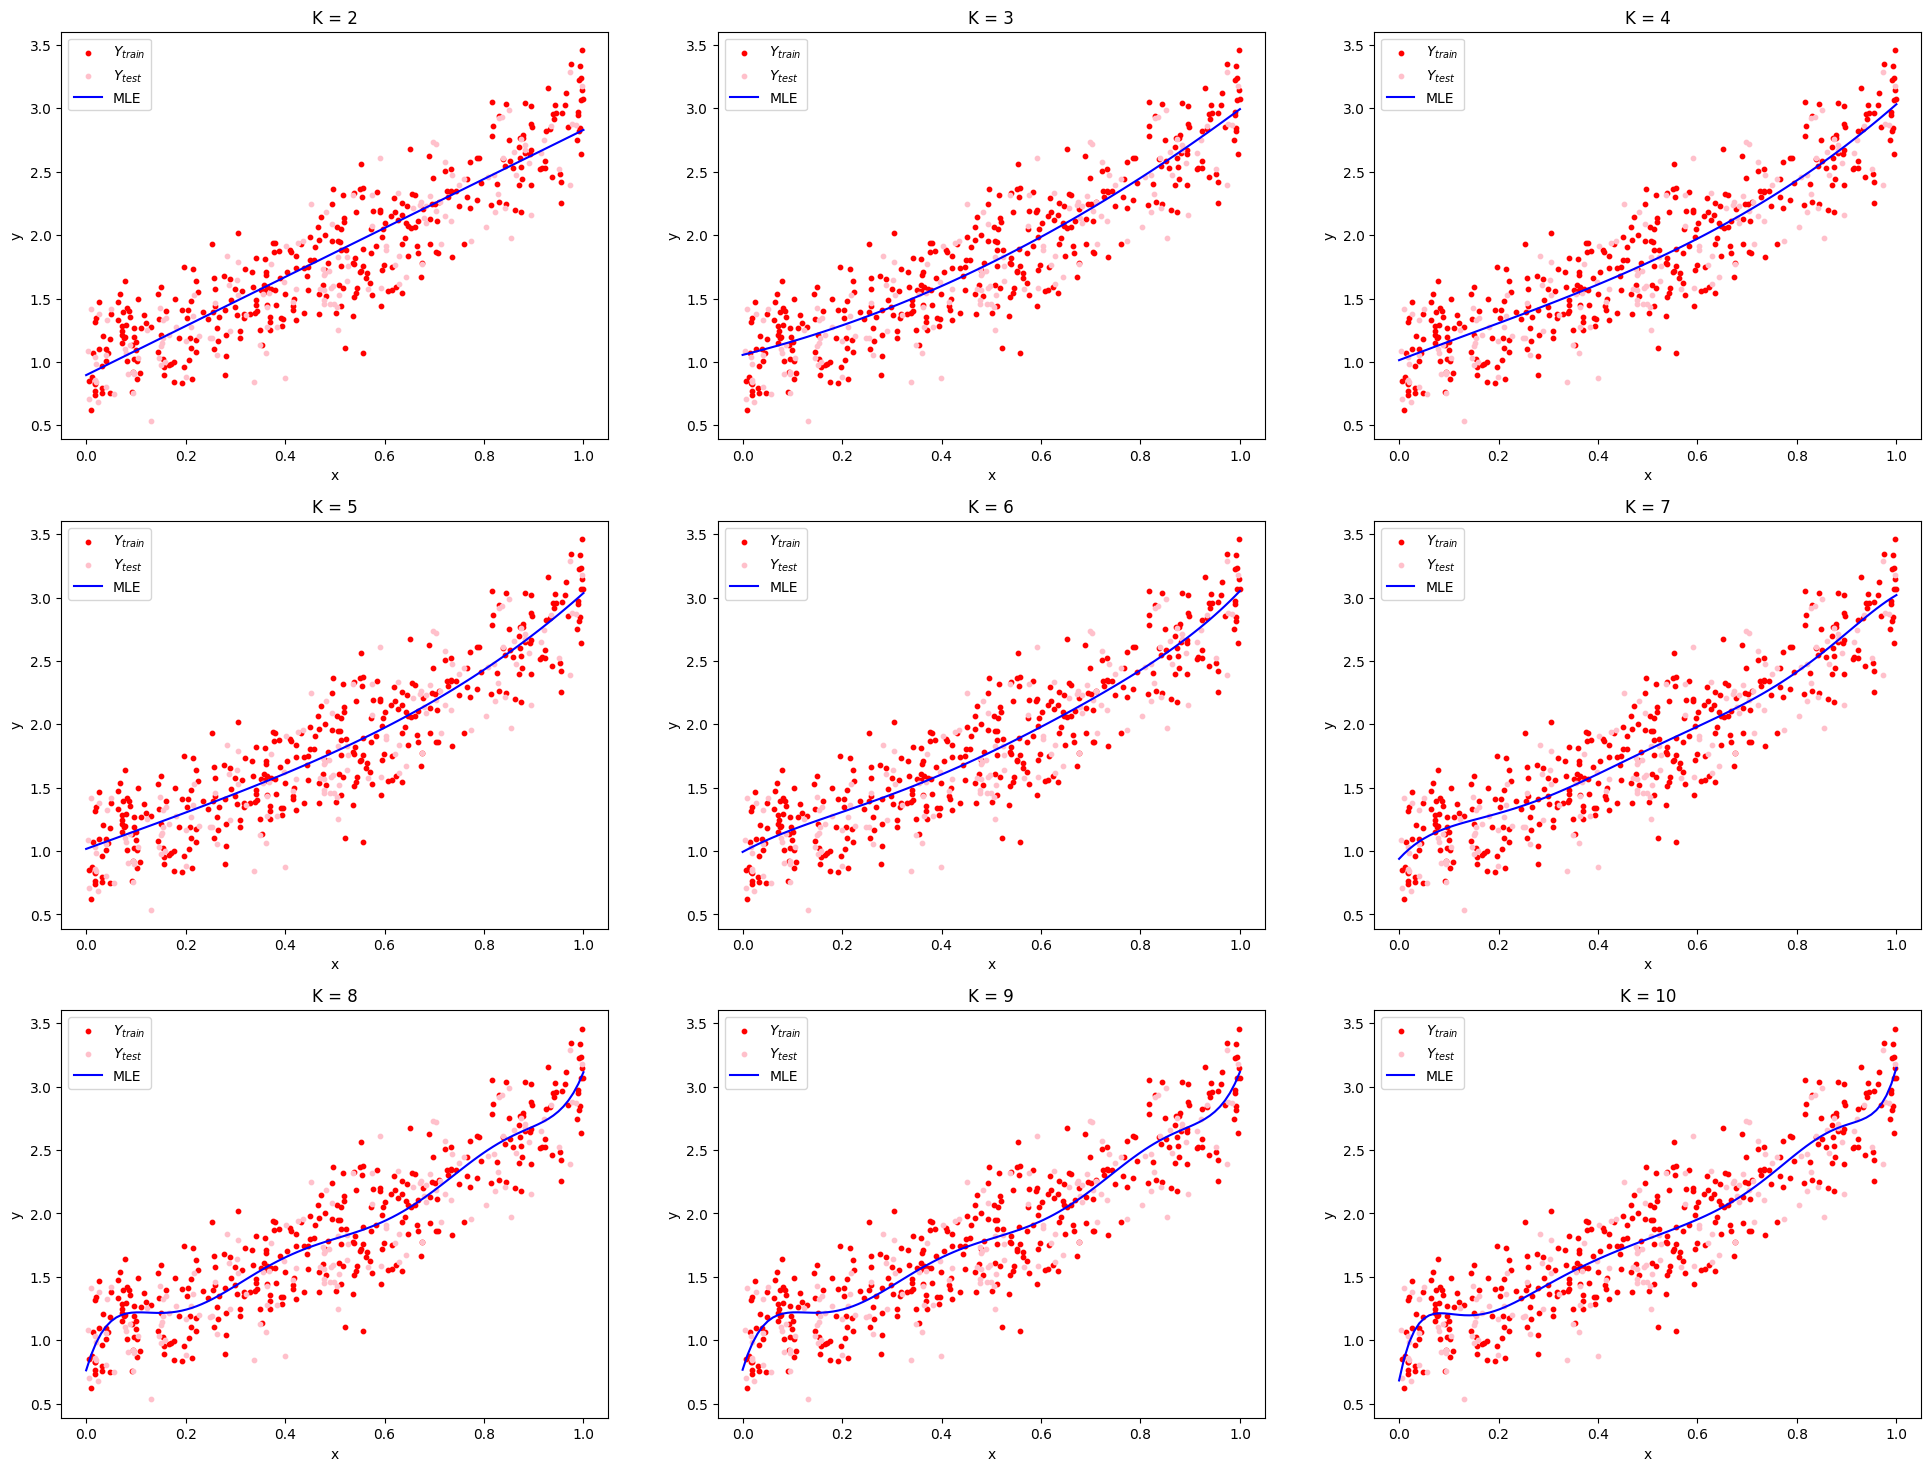

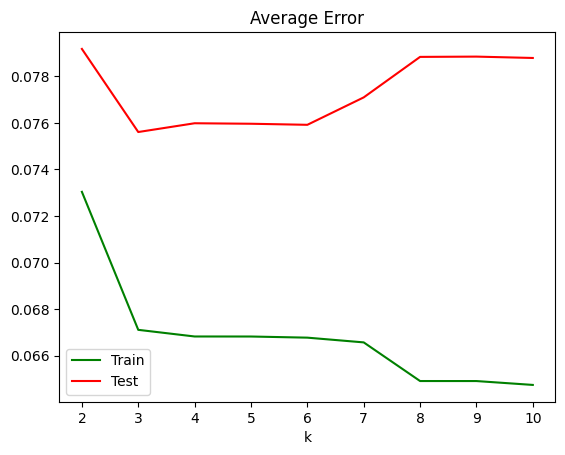

In [32]:

k_min = 2
k_max = 10
dk = k_max - k_min
plt.figure(figsize=(3 * 8, (dk//3 + 1)*6))

err_test = np.zeros((dk + 1,))
err_train = np.zeros((dk + 1,))
KK = np.arange(k_min, k_max + 1)

for k in range(k_min, k_max + 1):
    theta_mle = mle_est_plus(X, Y, k, "NE")
    
    XX = np.linspace(a, b, 100)
    YY = PolRegressor(XX, theta_mle)
    err_train[k - k_min] = average_error(theta_mle, X, Y)
    err_test[k - k_min] = average_error(theta_mle, Xtest, Ytest)
    
    plt.subplot(dk//3 + 1, 3, k - k_min + 1)
    plt.title(f"K = {k}")
    plt.scatter(X, Y, c= "red", s= 10)
    plt.scatter(Xtest, Ytest, c= "pink", s= 10)
    plt.plot(XX, YY, c= "blue")
    plt.legend(["$Y_{train}$", "$Y_{test}$", f"MLE"])
    plt.xlabel("x")
    plt.ylabel("y")
plt.figure()
plt.title("Average Error")
plt.plot(KK, err_train, c= "green")
plt.plot(KK, err_test, c= "red")
plt.legend(["Train", "Test"])
plt.xlabel("k")
plt.show()


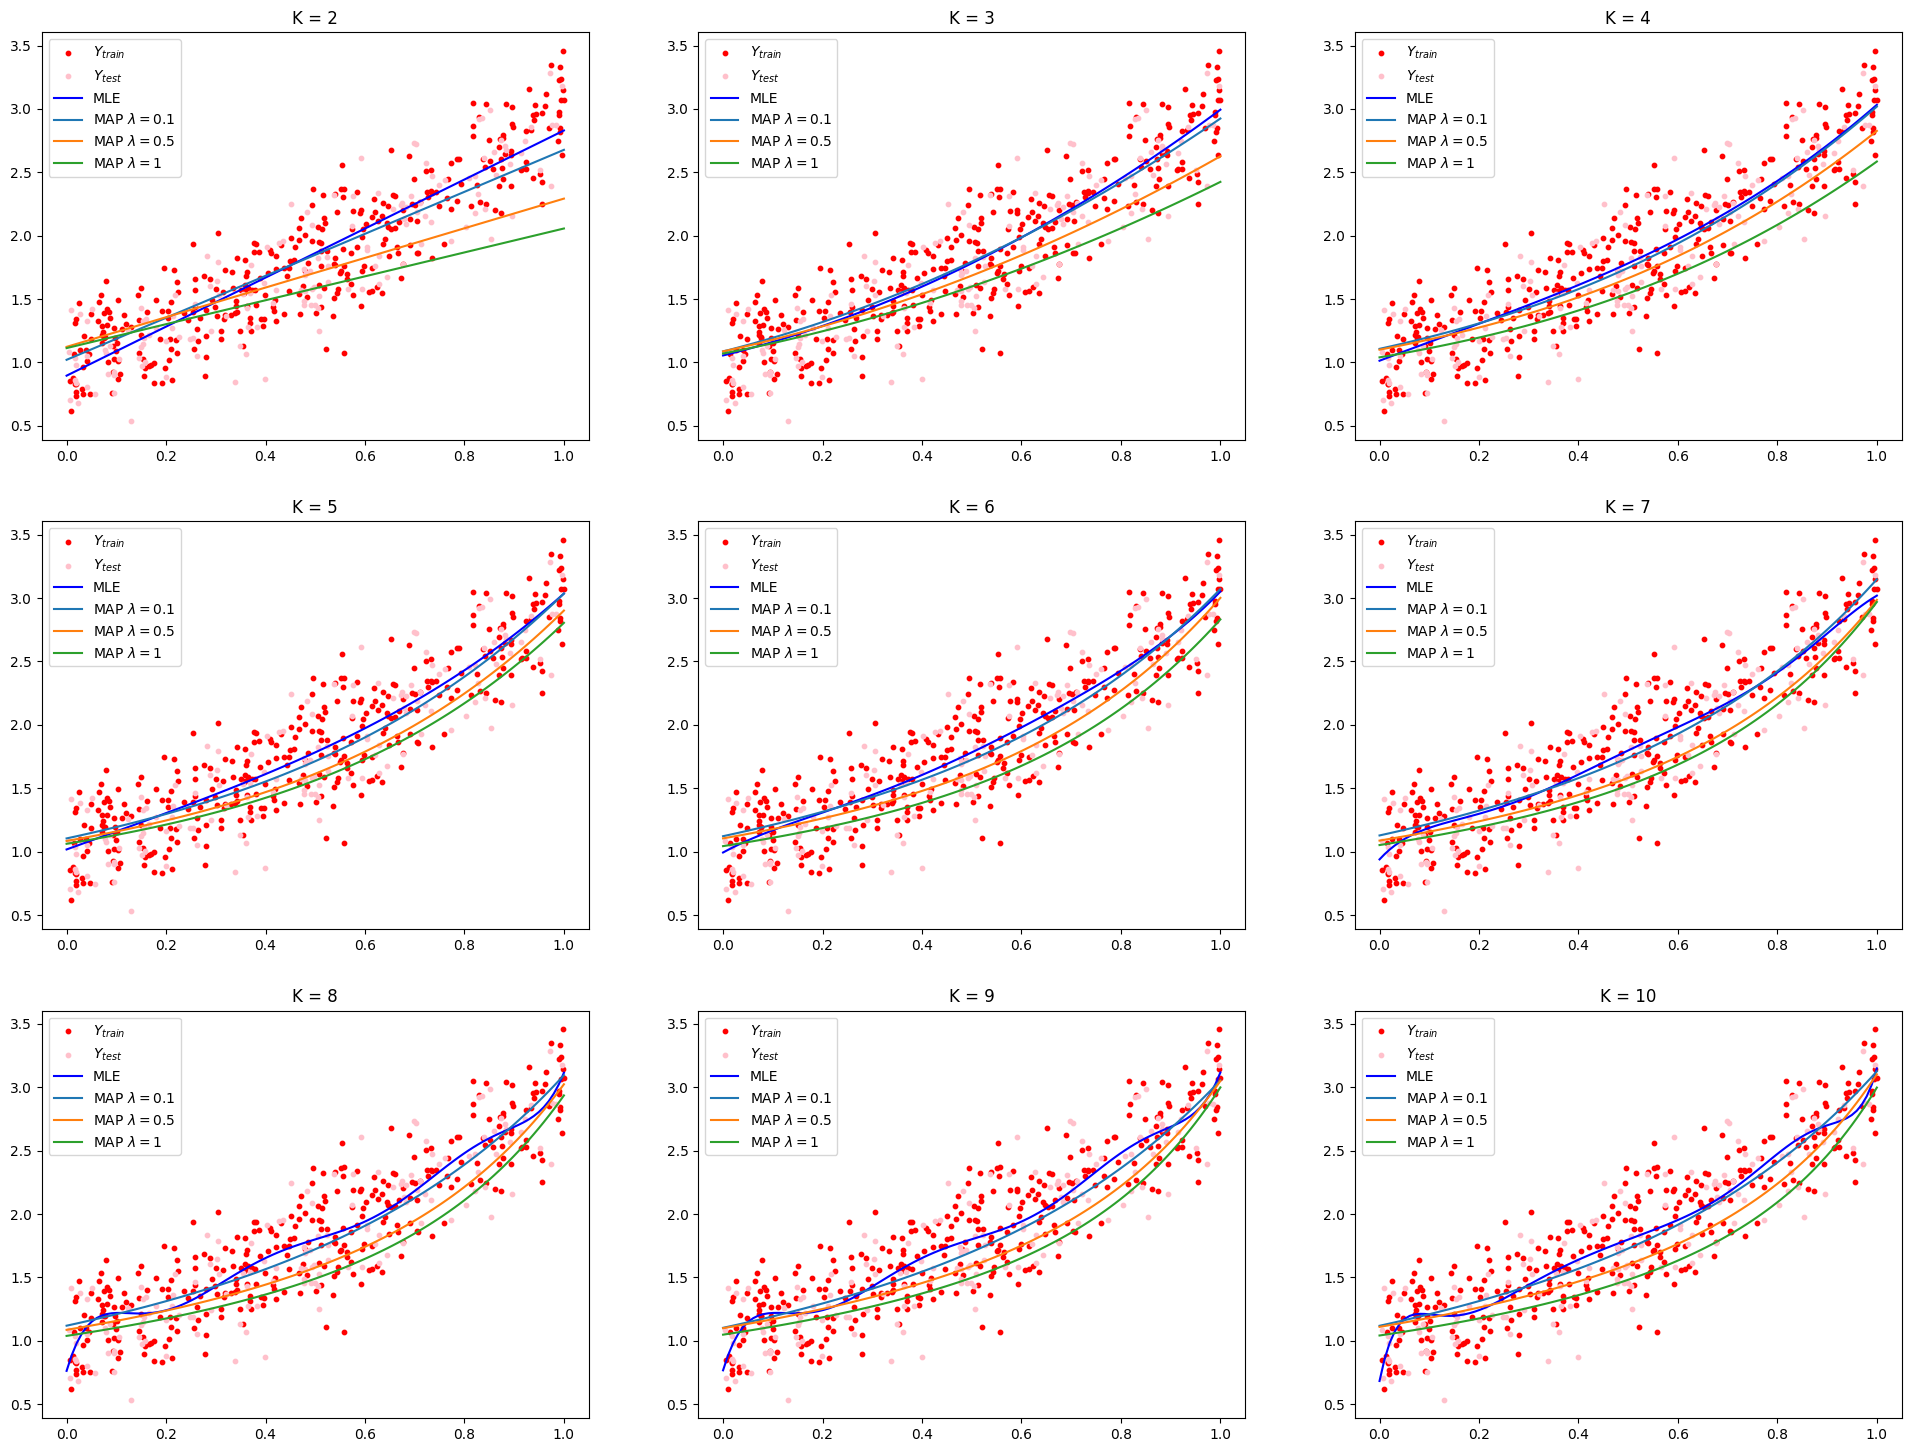

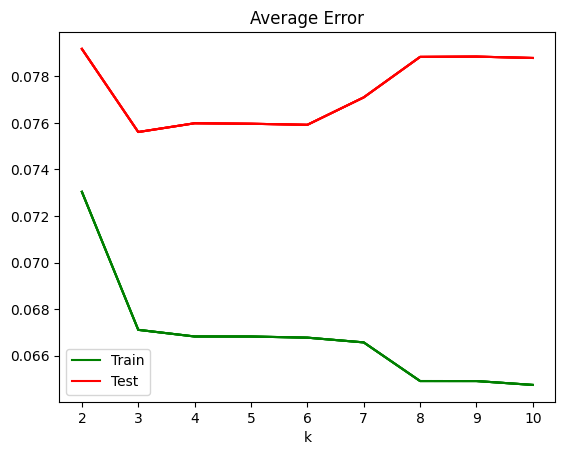

In [67]:
k_min = 2
k_max = 10
dk = k_max - k_min

lambdas = (.1, .5, 1)
plt.figure(figsize=(3 * 8, (dk//3 + 1)*6))

err_test = np.zeros((dk + 1, len(lambdas) + 1))
err_train = np.zeros((dk + 1, len(lambdas) + 1))
KK = np.arange(k_min, k_max + 1)

for ik, k in enumerate(KK):
    theta_mle = mle_est(X, Y, k)
    
    XX = np.linspace(a, b, 100)
    YYmle = PolRegressor(XX, theta_mle)
    
    plt.subplot(dk//3 + 1, 3, k - k_min + 1)
    plt.title(f"K = {k}")
    plt.scatter(X, Y, c= "red", s= 10)
    plt.scatter(Xtest, Ytest, c= "pink", s= 10)
    plt.plot(XX, YYmle, c= "blue")
    
    err_train[ik, 0] = average_error(theta_mle, X, Y)
    err_test[ik, 0] = average_error(theta_mle, Xtest, Ytest)
    
    for il, l in enumerate(lambdas):
        theta_map = map_est_plus(X, Y, k, l, "SGD")
        
        YYmap = PolRegressor(XX, theta_map)
        plt.plot(XX, YYmap)
        
        err_train[ik, il + 1] = average_error(theta_mle, X, Y)
        err_test[ik, il + 1] = average_error(theta_mle, Xtest, Ytest)
    
    plt.legend(["$Y_{train}$", "$Y_{test}$", f"MLE"] + ["MAP $\lambda = $" + f"{l}" for l in lambdas] )


plt.figure()
plt.title("Average Error")
plt.plot(KK, err_train[:, 0], c= "green")
plt.plot(KK, err_test[:, 0], c= "red")
for il, l in enumerate(lambdas):
    plt.plot(KK, err_train[:, il+1],c= "green")
    plt.plot(KK, err_test[:, il+1], c= "red")
plt.legend(["Train", "Test"])
plt.xlabel("k")
plt.show()

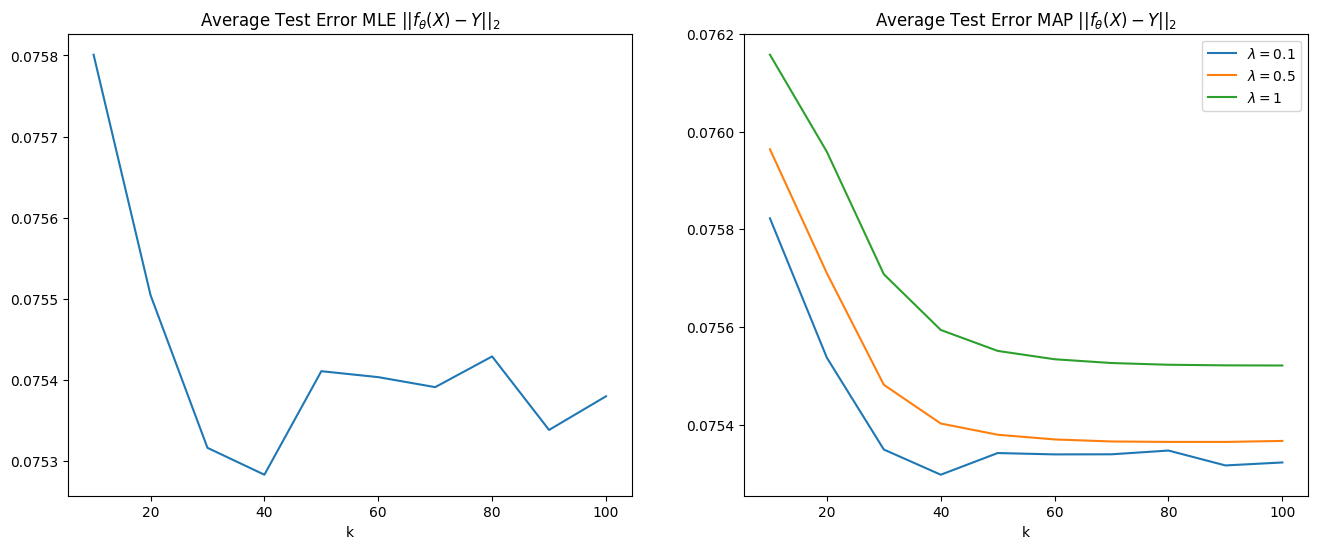

In [55]:
from IPython.display import clear_output

k_min = 10
k_max = 100
step = 10
KK = np.arange(k_min, k_max + 1, step)
lambdas =  lambdas = (.1, .5, 1) #[10**n for n in range(-1, -10, -1)] np.arange(.1, 1, .2)
err = np.zeros((len(KK), len(lambdas) + 1))

mod = "GD"
for k in KK:
    theta_mle = mle_est_plus(X, Y, k, mod)
    err[(k - k_min)//step, 0] = average_error(theta_mle, Xtest, Ytest)
        
    for i, l in enumerate(lambdas):
        theta_map = map_est_plus(X, Y, k, l, mod)
        err[(k - k_min)//step, i + 1] = average_error(theta_map, Xtest, Ytest)
clear_output(wait=True)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Average Test Error MLE ||$f_\u03B8(X) - Y||_2$")
plt.xlabel("k")
plt.plot(KK, err[:, 0])
plt.subplot(1, 2, 2)
plt.plot(KK, err[:, 1:])
plt.title("Average Test Error MAP ||$f_\u03B8(X) - Y||_2$")
plt.xlabel("k")
plt.legend([f"$\lambda = {np.round(l, 1)}$" for l in lambdas])
plt.show()

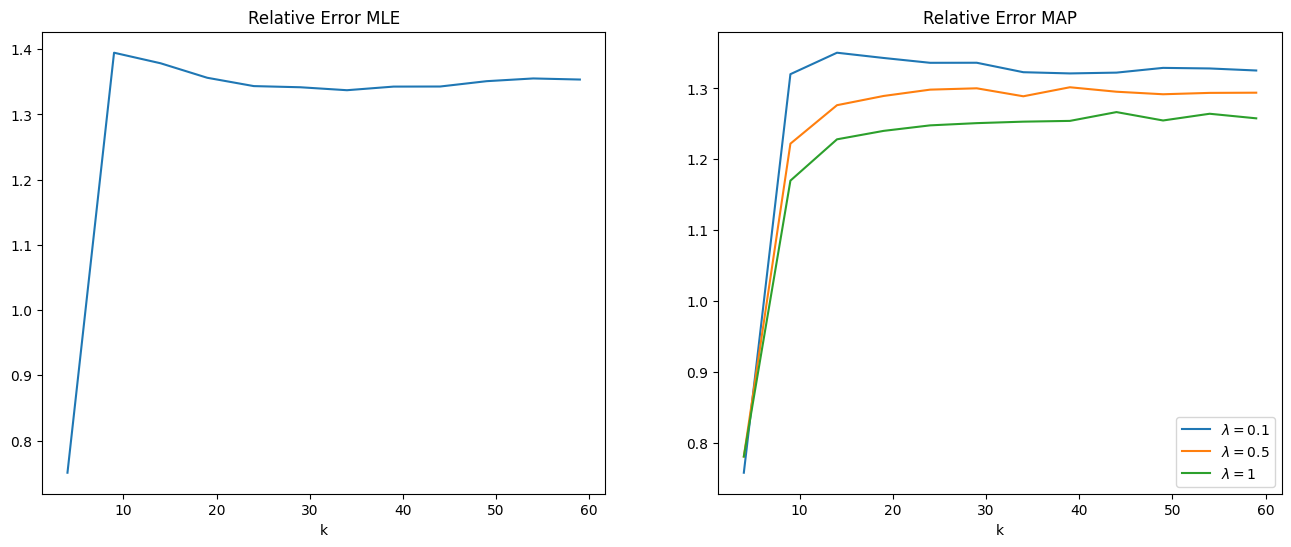

In [70]:
######################################################################################
def Err(theta):
    thetatrue = np.concatenate((theta_true, np.zeros((len(theta) - len(theta_true)))))
    return np.linalg.norm(theta - thetatrue, 2) / np.linalg.norm(thetatrue, 2)
######################################################################################

k_max = 60
step = 5
KK = np.arange(K + 1, k_max, step)
err_rel = np.zeros((len(KK), len(lambdas) + 1))

mod = "SGD"
for i, k in enumerate(KK):
    theta_mle = mle_est_plus(X, Y, k, mod)
    err_rel[i, 0] = Err(theta_mle)
    
    for j, l in enumerate(lambdas):
        theta_map = map_est_plus(X, Y, k, l, mod)
        err_rel[i, j + 1] = Err(theta_map)
clear_output(wait=True)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(KK, err_rel[:, 0])
plt.xlabel("k")
plt.title("Relative Error MLE")

plt.subplot(1, 2, 2)
plt.plot(KK, err_rel[:, 1:])    
plt.xlabel("k")
plt.title("Relative Error MAP")
plt.legend([f"$\lambda = {np.round(l, 1)}$" for l in lambdas])

plt.show()